In [75]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
import csv
import pandas as pd
import array
random.seed(134)

PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32

# HW2 -- RNN/CNN-based Natural Language Inference

# 1 Load dataset:

In [76]:
def load_data(PATH):
    
    data_set = []
    with open(PATH) as tsvfile:
        reader = csv.reader(tsvfile, delimiter = '\t')
        for line in list(reader)[1:]:
            data_set.append(tuple(list(x.strip(' ').split(' ')) for x in line))
            
    return data_set

In [80]:
def load_data1(PATH):
    
    data_set = []
    with open(PATH) as tsvfile:
        reader = csv.reader(tsvfile, delimiter = '\t')
        for line in list(reader)[1:]:
            data_set.append(tuple(list(line)))
            
    return data_set

In [82]:
val_data1= load_data1('snli_val.tsv')

In [77]:
train_data = load_data('snli_train.tsv')
val_data = load_data('snli_val.tsv')

In [114]:
len(train_data)

100000

In [115]:
len(val_data)

1000

# Using pretrained word embeddings:

In [78]:
ft_home = '/Users/xiaofanbai/'
words_to_load = 50000

import numpy as np

with open(ft_home + 'wiki-news-300d-1M.vec') as f:
    loaded_embeddings_ft = np.zeros((words_to_load+2, 300))
    words_ft = {}
    idx2words_ft = {}
    ordered_words_ft = []
    loaded_embeddings_ft[0, :] = np.random.rand(300)
    loaded_embeddings_ft[1, :] = np.random.rand(300)
    words_ft['<pad>'] = 0
    words_ft['<unk>'] = 1
    idx2words_ft[0] = '<pad>'
    idx2words_ft[1] = '<unk>'
    
    for i, line in enumerate(f):
        #s[0] is the word name
        #s[1:] is the weights
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings_ft[i+2, :] = np.asarray(s[1:])
        words_ft[s[0]] = i+2
        idx2words_ft[i+2] = s[0]
        ordered_words_ft.append(s[0])
    ordered_words_ft = ['<pad>', '<unk>'] + ordered_words_ft
    
train_data_flat = np.asarray(train_data).flatten()
MAX_WORD_LENGTH = max([len(word) for word in train_data_flat])

In [60]:
with open('data.pkl', 'rb') as f:
    words_ft, loaded_embeddings_ft, MAX_WORD_LENGTH = pkl.load(f)

So we now have the word2id, id2words, loaded_embedding_ft, ordered_words_ft, max_len.

# Build dataloader:

In [61]:
class Sloader(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_tuple, char2id):
        """
        @param hypo_list: list of character
        @param pre_list: list of character
        @param target_list: list of targets

        """
        self.hypo_list, self.pre_list, self.target_list,  = zip(*data_tuple)
        assert (len(self.hypo_list) == len(self.target_list))
        assert (len(self.pre_list) == len(self.target_list))
        
        self.char2id = char2id

    def __len__(self):
        return len(self.hypo_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        char_idx_hypo = [self.char2id[c] if c in self.char2id.keys() else UNK_IDX  for c in self.hypo_list[key][:MAX_WORD_LENGTH]]
        char_idx_pre = [self.char2id[c] if c in self.char2id.keys() else UNK_IDX  for c in self.pre_list[key][:MAX_WORD_LENGTH]]
        if self.target_list[key] == ['neutral']:
            label = 0
        elif self.target_list[key] == ['contradiction']:
            label = 1
        else:
            label = 2
            
        return [char_idx_hypo, char_idx_pre, len(char_idx_hypo), len(char_idx_pre), label]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    pre_data_list = []
    hypo_data_list = []
    label_list = []
    pre_length_list = []
    hypo_length_list = []

    for datum in batch:
        
        label_list.append(datum[4])
        pre_length_list.append(datum[2])
        hypo_length_list.append(datum[3])
        
    # padding
    for datum in batch:
        pre_padded_vec = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_WORD_LENGTH-datum[2])),
                                mode="constant", constant_values=0)
        hypo_padded_vec = np.pad(np.array(datum[1]),
                                pad_width=((0,MAX_WORD_LENGTH-datum[3])),
                                mode="constant", constant_values=0)
        #print(hypo_padded_vec)
        pre_data_list.append(pre_padded_vec)
        #print(hypo_data_list)
        hypo_data_list.append(hypo_padded_vec)
        

    #ind_dec_order = np.argsort(length_list)[::-1]
    #data_list = np.array(data_list)[ind_dec_order]
    #length_list = np.array(length_list)[ind_dec_order]
    #label_list = np.array(label_list)[ind_dec_order]
    #print(hypo_data_list)
    return [torch.from_numpy(np.array(pre_data_list)).cuda(), torch.from_numpy(np.array(hypo_data_list)).cuda(), torch.LongTensor(pre_length_list).cuda(), torch.LongTensor(hypo_length_list).cuda(), torch.LongTensor(label_list).cuda()]



In [62]:
# Build train, valid and test dataloaders

train_dataset = Sloader(train_data, words_ft)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

val_dataset = Sloader(val_data, words_ft)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

# 2 CNN Model:

In [73]:
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_classes, kernel_size, p_drop = 0):

        super(CNN, self).__init__()

        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(loaded_embeddings_ft), freeze=True).cuda()
        
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=1)

        self.linear1 = nn.Linear(2*self.hidden_size, self.hidden_size)
        self.linear2 = nn.Linear(self.hidden_size, num_classes)
        
        self.dropout = nn.Dropout(p = p_drop)
        
    def forward(self, x1, x2, len_x1, len_x2):
        batch_size, seq_len = x1.size()
        
        x1 = x1.cuda()
        x2 = x2.cuda()
        len_x1 = len_x1.cuda()
        len_x2 = len_x2.cuda()
        
        embed_pre = self.embedding(x1).cuda()
        embed_hypo = self.embedding(x2).cuda()
                
        #conv1
        #(batch_size, num_channels, length) expected input
        hidden_pre = self.conv1(embed_pre.transpose(1,2)).transpose(1,2)
        hidden_pre = self.dropout(hidden_pre)
        hidden_pre = F.relu(hidden_pre.contiguous().view(-1, hidden_pre.size(-1))).view(batch_size, seq_len, hidden_pre.size(-1))
        
        hidden_hypo = self.conv1(embed_hypo.transpose(1,2)).transpose(1,2)
        hidden_hypo = self.dropout(hidden_hypo)
        hidden_hypo = F.relu(hidden_hypo.contiguous().view(-1, hidden_hypo.size(-1))).view(batch_size, seq_len, hidden_hypo.size(-1))
        
        #conv2
        hidden_pre = self.conv2(hidden_pre.transpose(1,2)).transpose(1,2)
        hidden_pre = self.dropout(hidden_pre)
        hidden_pre = F.relu(hidden_pre.contiguous().view(-1, hidden_pre.size(-1))).view(batch_size, seq_len, hidden_pre.size(-1))
        
        hidden_hypo = self.conv2(hidden_hypo.transpose(1,2)).transpose(1,2)
        hidden_hypo = self.dropout(hidden_hypo)
        hidden_hypo = F.relu(hidden_hypo.contiguous().view(-1, hidden_hypo.size(-1))).view(batch_size, seq_len, hidden_hypo.size(-1))
        
        #maxpool
        hidden_pre, _ = hidden_pre.max(dim = 1)
        hidden_hypo, _ = hidden_hypo.max(dim = 1)
        
        #concat premise and hypothesis
        assert (hidden_pre.size() == hidden_hypo.size())
        concat = torch.cat([hidden_pre, hidden_hypo], dim = 1)
        output = self.linear1(concat)
        output = F.relu(output)
        logits = self.linear2(output)
        
        return logits
    
    

In [74]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data_pre, data_hypo, len_pre, len_hypo, labels in loader:
        #data_batch, lengths_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_pre, data_hypo, len_pre, len_hypo), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)


# 3.1 Training CNN on SNLI:

# Tuning hidden_size and probability for dropout in CNN

In [75]:
#parameter:
emb_size=300
num_classes=3
kernel_size=3
learning_rate = 3e-3
num_epochs = 8

hidden_size_list = [100,200,300]
p_dropout_list = [0,0.2,0.5,0.8]

val_accuracy_CNN = {}
train_accuracy_CNN = {}

for hidden_size in hidden_size_list:
    for p_drop in p_dropout_list:
        model = CNN(emb_size=300, hidden_size=hidden_size, num_classes=3, kernel_size=3, p_drop = p_drop).cuda()
        learning_rate = 3e-3
        num_epochs = 8
        # Criterion and Optimizer
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        total_step = len(train_loader)
        val_accuracy_CNN[hidden_size, p_drop] = []
        train_accuracy_CNN[hidden_size, p_drop] = []
        for epoch in range(num_epochs):
            for i, (data_pre,data_hypo,len_pre,len_hypo,labels) in enumerate(train_loader):
                model.train()
                optimizer.zero_grad()

                # Forward pass
                outputs = model(data_pre, data_hypo, len_pre, len_hypo)
                loss = criterion(outputs, labels)

                # Backward and optimize
                loss.backward()
                optimizer.step()

            # validate per epoch
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            val_accuracy_CNN[hidden_size,p_drop].append(val_acc)
            train_accuracy_CNN[hidden_size,p_drop].append(train_acc)

            print('Epoch: [{}/{}], Validation Acc: {}, Training Acc:{}'.format(
                       epoch+1, num_epochs, val_acc, train_acc))   

Epoch: [1/8], Validation Acc: 44.2, Training Acc:44.526
Epoch: [2/8], Validation Acc: 47.1, Training Acc:47.972
Epoch: [3/8], Validation Acc: 46.0, Training Acc:48.754
Epoch: [4/8], Validation Acc: 46.9, Training Acc:49.35
Epoch: [5/8], Validation Acc: 48.8, Training Acc:49.87
Epoch: [6/8], Validation Acc: 46.0, Training Acc:50.356
Epoch: [7/8], Validation Acc: 48.2, Training Acc:50.171
Epoch: [8/8], Validation Acc: 47.5, Training Acc:50.625
Epoch: [1/8], Validation Acc: 43.1, Training Acc:44.334
Epoch: [2/8], Validation Acc: 44.8, Training Acc:45.609
Epoch: [3/8], Validation Acc: 43.9, Training Acc:46.412
Epoch: [4/8], Validation Acc: 45.0, Training Acc:46.252
Epoch: [5/8], Validation Acc: 44.2, Training Acc:46.892
Epoch: [6/8], Validation Acc: 44.8, Training Acc:47.399
Epoch: [7/8], Validation Acc: 44.5, Training Acc:47.289
Epoch: [8/8], Validation Acc: 45.3, Training Acc:47.744
Epoch: [1/8], Validation Acc: 42.9, Training Acc:42.94
Epoch: [2/8], Validation Acc: 43.9, Training Acc:43

# Accuracy Visualization:

In [9]:
import matplotlib.pyplot as plt

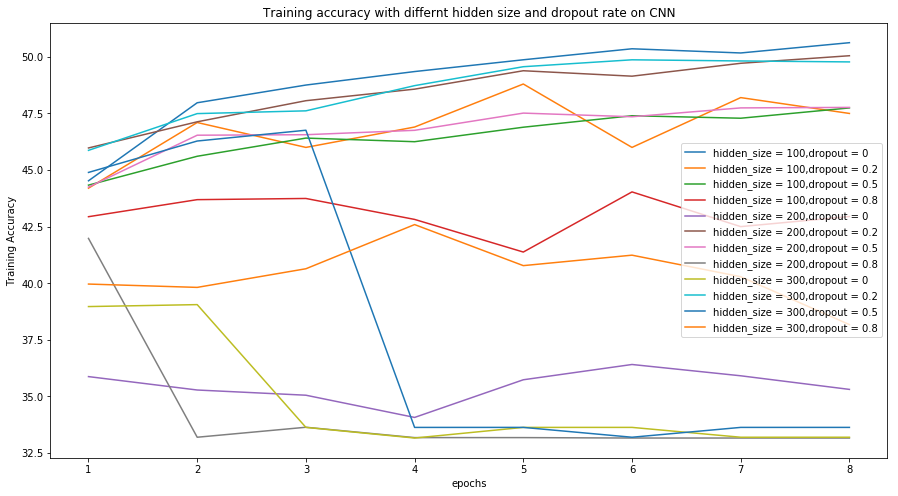

In [112]:
plt.figure(figsize=(15,8))
epochs = [1,2,3,4,5,6,7,8]
for keys in train_accuracy_CNN:
    line,  = plt.plot(epochs, train_accuracy_CNN[keys], label= "hidden_size = {},dropout = {}".format(keys[0],keys[1]))
    plt.legend(loc = 'right')
    
plt.title('Training accuracy with differnt hidden size and dropout rate on CNN')
plt.xlabel("epochs")
plt.ylabel("Training Accuracy")
plt.show()

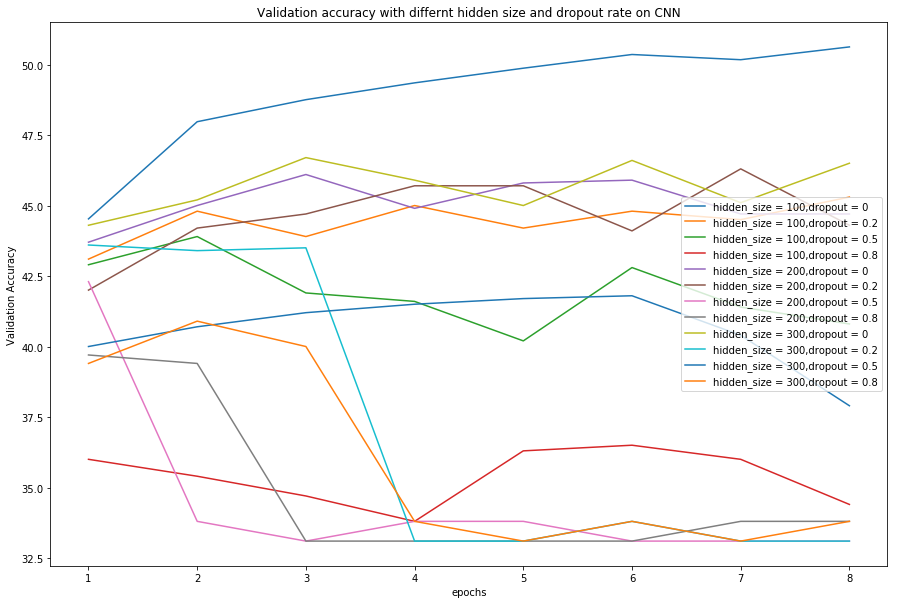

In [136]:
plt.figure(figsize=(15,10))
epochs = [1,2,3,4,5,6,7,8]
for keys in val_accuracy_CNN:

    line,  = plt.plot(epochs, val_accuracy_CNN[keys], label= "hidden_size = {},dropout = {}".format(keys[0],keys[1]))
    plt.legend(loc = 'right')
    
plt.title('Validation accuracy with differnt hidden size and dropout rate on CNN')
plt.xlabel("epochs")
plt.ylabel("Validation Accuracy")
plt.show()

The best model for CNN is for hidden_size = 100, dropout = 0 at training epoch 6.

# 2 RNN Model:

In [76]:
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, pro_drop = 0.2):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes

        super(RNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(loaded_embeddings_ft), freeze=True)
        
        self.rnn = nn.GRU(emb_size, self.hidden_size, self.num_layers,bidirectional=True, batch_first=True)
        
        self.linear1 = nn.Linear(4*self.hidden_size, self.hidden_size)
        self.linear2 = nn.Linear(self.hidden_size, num_classes)

        self.dropout = nn.Dropout(p = pro_drop)
        
    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(2*self.num_layers, batch_size, self.hidden_size).cuda()
        return hidden

    def forward(self, x1, x2, len_x1, len_x2):
        # reset hidden state
        
        batch_size, seq_len = x1.size()
        
        x1 = x1.cuda()
        x2 = x2.cuda()
        len_x1 = len_x1.cuda()
        len_x2 = len_x2.cuda()
        
        ##sort based on index, to get ordered indexes 
        pre_length_sorted, pre_index = len_x1.sort(0, descending=True)
        hypo_length_sorted, hypo_index = len_x2.sort(0, descending=True)
        
        ##update input by sorted index 
        x1 = x1[pre_index]
        x2 = x2[hypo_index]
        
        # get embedding of characters
        embed_pre = self.embedding(x1)
        embed_hypo = self.embedding(x2)
        
        # pack data with length of data
        packed_pre = torch.nn.utils.rnn.pack_padded_sequence(embed_pre, pre_length_sorted.cpu().numpy(), batch_first=True)
        packed_hypo = torch.nn.utils.rnn.pack_padded_sequence(embed_hypo, hypo_length_sorted.cpu().numpy(), batch_first=True)
        
        # initial hidden layer
        hidden_pre = self.init_hidden(batch_size)
        hidden_hypo = self.init_hidden(batch_size)
        
        # pass to gru0
        _, hidden_pre = self.rnn(packed_pre, hidden_pre)
        _, hidden_hypo = self.rnn(packed_hypo, hidden_hypo)
        
        hidden_pre = self.dropout(hidden_pre)
        hidden_hypo = self.dropout(hidden_pre)
        
        # undo packing
        _, pre_unsort_index = pre_index.sort(0)
        _, hypo_unsort_index = hypo_index.sort(0)
        
        out_pre = torch.cat((hidden_pre[0],hidden_pre[1]), dim = 1)[pre_unsort_index]
        out_hypo = torch.cat((hidden_hypo[0],hidden_hypo[1]), dim = 1)[hypo_unsort_index]
        
        # sum hidden activations of RNN across time
        rnn_out = torch.cat((out_pre, out_hypo), dim = 1)
        
        rnn_out = self.linear1(rnn_out)
        rnn_out = self.dropout(rnn_out)
        rnn_out = F.relu(rnn_out)
        logits = self.linear2(rnn_out)
        
        return logits


# 3.1 Training RNN on SNLI:

# Tuning hidden_size and dropout probability in RNN:

In [77]:
#Parameters
emb_size=300
num_layers=1
num_classes=3
learning_rate = 3e-3
num_epochs = 8
hidden_size_list = [100,200,300]
p_dropout_list = [0,0.2,0.5,0.8]

val_accuracy_RNN = {}
train_accuracy_RNN = {}

for hidden_size in hidden_size_list:
    for p_dropout in p_dropout_list:
        
        model = RNN(emb_size=300, hidden_size=hidden_size, num_layers=1,num_classes=3, pro_drop = p_dropout).cuda()
        learning_rate = 3e-3
        num_epochs = 8
        # Criterion and Optimizer
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        total_step = len(train_loader)
        val_accuracy_RNN[hidden_size, p_dropout] = []
        train_accuracy_RNN[hidden_size, p_dropout] = []
        for epoch in range(num_epochs):
            for i, (data_pre,data_hypo,len_pre,len_hypo,labels) in enumerate(train_loader):
                model.train()
                optimizer.zero_grad()

                # Forward pass
                outputs = model(data_pre, data_hypo, len_pre, len_hypo)
                loss = criterion(outputs, labels)

                # Backward and optimize
                loss.backward()
                optimizer.step()

            # validate per epoch
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            val_accuracy_RNN[hidden_size, p_dropout].append(val_acc)
            train_accuracy_RNN[hidden_size, p_dropout].append(train_acc)

            print('Epoch: [{}/{}], Validation Acc: {}, Training Acc:{}'.format(
                       epoch+1, num_epochs, val_acc, train_acc))   
            
            
            

Epoch: [1/8], Validation Acc: 45.8, Training Acc:47.484
Epoch: [2/8], Validation Acc: 46.2, Training Acc:48.16
Epoch: [3/8], Validation Acc: 46.9, Training Acc:49.279
Epoch: [4/8], Validation Acc: 49.1, Training Acc:50.343
Epoch: [5/8], Validation Acc: 45.6, Training Acc:50.385
Epoch: [6/8], Validation Acc: 48.0, Training Acc:50.573
Epoch: [7/8], Validation Acc: 48.1, Training Acc:51.446
Epoch: [8/8], Validation Acc: 47.8, Training Acc:51.142
Epoch: [1/8], Validation Acc: 44.7, Training Acc:47.349
Epoch: [2/8], Validation Acc: 45.2, Training Acc:47.656
Epoch: [3/8], Validation Acc: 45.4, Training Acc:48.874
Epoch: [4/8], Validation Acc: 46.9, Training Acc:49.051
Epoch: [5/8], Validation Acc: 47.4, Training Acc:49.028
Epoch: [6/8], Validation Acc: 46.6, Training Acc:49.361
Epoch: [7/8], Validation Acc: 46.3, Training Acc:50.141
Epoch: [8/8], Validation Acc: 47.5, Training Acc:50.568
Epoch: [1/8], Validation Acc: 44.0, Training Acc:44.889
Epoch: [2/8], Validation Acc: 46.6, Training Acc:

# Accuracy Visualization:

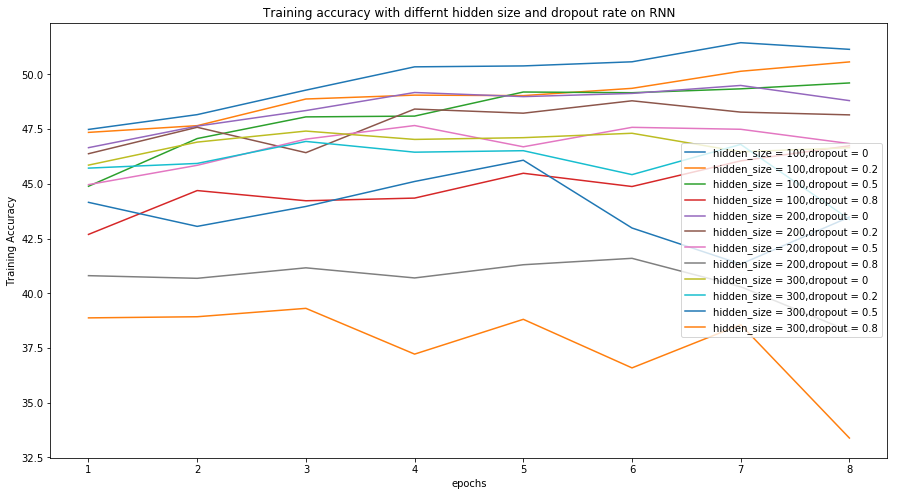

In [135]:
plt.figure(figsize=(15,8))
epochs = [1,2,3,4,5,6,7,8]
for keys in train_accuracy_RNN:
    line,  = plt.plot(epochs, train_accuracy_RNN[keys], label= "hidden_size = {},dropout = {}".format(keys[0],keys[1]))
    plt.legend(loc = 'right')
    
plt.title('Training accuracy with differnt hidden size and dropout rate on RNN')
plt.xlabel("epochs")
plt.ylabel("Training Accuracy")
plt.show()

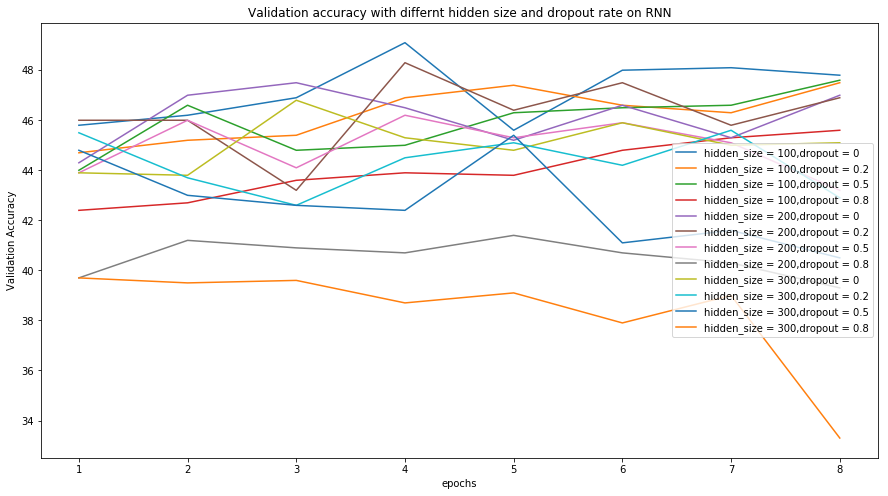

In [131]:
plt.figure(figsize=(15,8))
epochs = [1,2,3,4,5,6,7,8]
for keys in val_accuracy_RNN:
    line,  = plt.plot(epochs, val_accuracy_RNN[keys], label= "hidden_size = {},dropout = {}".format(keys[0],keys[1]))
    plt.legend(loc = 'right')
    
plt.title('Validation accuracy with differnt hidden size and dropout rate on RNN')
plt.xlabel("epochs")
plt.ylabel("Validation Accuracy")
plt.show()

The best model for RNN is for hidden_size = 100, dropout = 0 at training epoch 4.

# 3.2 Evaluate on MultiNli and get correct and incorrect example on SNLI vali:

# Data preprocessing: split the dataset by genre and create dataloader.

In [117]:
Mnli_val = load_data('mnli_val.tsv')

In [39]:
genre = []
for i in Mnli_val:
    genre.append(i[3][0])
genre = set(genre)

In [40]:
Mnli_val_fic = []
Mnli_val_slate = []
Mnli_val_gov = []
Mnli_val_tel = []
Mnli_val_tra = []

In [41]:
for i in Mnli_val:
    if i[3][0] == "fiction":
        Mnli_val_fic.append(i[:3])
    elif i[3][0] == "slate":
        Mnli_val_slate.append(i[:3])
    elif i[3][0] == "government":
        Mnli_val_gov.append(i[:3])
    elif i[3][0] == "telephone":
        Mnli_val_tel.append(i[:3])
    elif i[3][0] == "travel":
        Mnli_val_tra.append(i[:3])

In [42]:
len(Mnli_val_fic)+len(Mnli_val_slate)+len(Mnli_val_gov)+len(Mnli_val_tel)+len(Mnli_val_tra)

5000

In [43]:
Mnli_val_fic = Sloader(Mnli_val_fic, words_ft)
Mnli_val_fic_loader = torch.utils.data.DataLoader(dataset=Mnli_val_fic,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

Mnli_val_slate = Sloader(Mnli_val_slate, words_ft)
Mnli_val_slate_loader = torch.utils.data.DataLoader(dataset=Mnli_val_slate,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)
Mnli_val_gov = Sloader(Mnli_val_gov, words_ft)
Mnli_val_gov_loader = torch.utils.data.DataLoader(dataset=Mnli_val_gov,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

Mnli_val_tel = Sloader(Mnli_val_tel, words_ft)
Mnli_val_tel_loader = torch.utils.data.DataLoader(dataset=Mnli_val_tel,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)
Mnli_val_tra = Sloader(Mnli_val_tra, words_ft)
Mnli_val_tra_loader = torch.utils.data.DataLoader(dataset=Mnli_val_tra,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

# Load and test performation on best CNN model using Mnli dataset:

In [78]:
#choose and train best CNN model
model = CNN(emb_size=100, hidden_size=200, num_classes=3, kernel_size=3, p_drop = 0).cuda()
learning_rate = 3e-4
num_epochs = 10
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (data_pre,data_hypo,len_pre,len_hypo,labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        outputs = model(data_pre, data_hypo, len_pre, len_hypo)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

# Get 3 correct and 3 incorrect outputs on snli Validation set:

In [92]:
pred_label_CNN = []
true_label_CNN = []
data_CNN = []
cnt = 0
for data_pre, data_hypo, len_pre, len_hypo, labels in val_loader:
    if cnt >30:
          break
    outputs = F.softmax(model(data_pre, data_hypo, len_pre, len_hypo), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    
    data_CNN.append(tuple(data_pre, data_hypo))
    true_label_CNN.append(labels.view_as(predicted))
    pred_label_CNN.append(predicted)
    
    cnt+=1

In [93]:
print("Correct:{}".format(val_data1[0]))
print("Correct:{}".format(val_data1[1]))
print("Correct:{}".format(val_data1[3]))
print("Incorrect:{}".format(val_data1[2]))
print("Incorrect:{}".format(val_data1[5]))
print("Incorrect:{}".format(val_data1[8]))


Correct:('Three women on a stage , one wearing red shoes , black pants , and a gray shirt is sitting on a prop , another is sitting on the floor , and the third wearing a black shirt and pants is standing , as a gentleman in the back tunes an instrument .', 'There are two women standing on the stage', 'contradiction')
Correct:('Four people sit on a subway two read books , one looks at a cellphone and is wearing knee high boots .', 'Multiple people are on a subway together , with each of them doing their own thing .', 'entailment')
Correct:('Man in overalls with two horses .', 'a man in overalls with two horses', 'entailment')
Incorrect:('bicycles stationed while a group of people socialize .', 'People get together near a stand of bicycles .', 'entailment')
Incorrect:('Two people are in a green forest .', 'The forest is not dead .', 'entailment')
Incorrect:('A group of numbered participants walk down the street together .', 'Participants wait for the beginning of the walkathon .', 'neut

# Get Mnli Accuracy for best CNN:

In [98]:
val_accuracy_Mnli_CNN = []
genre = ["fiction","slate","government","telephone","travel"]
loader = [Mnli_val_fic_loader,Mnli_val_slate_loader,Mnli_val_gov_loader,Mnli_val_tel_loader,Mnli_val_tra_loader]
for i in range(len(loader)):
    
    val_acc = test_model(loader[i], model)
    val_accuracy_Mnli_CNN.append(val_acc)

    print('Acc for genre {}, Validation Acc: {}'.format(
                  genre[i], val_acc))

Acc for genre fiction, Validation Acc: 43.81909547738694
Acc for genre slate, Validation Acc: 40.7185628742515
Acc for genre government, Validation Acc: 43.110236220472444
Acc for genre telephone, Validation Acc: 44.776119402985074
Acc for genre travel, Validation Acc: 44.60285132382892


# Load and test performation on RNN model:

In [94]:
#choose and train best RNN model
model = RNN(emb_size=300, hidden_size=200, num_classes=3,num_layers=1, pro_drop = 0.5).cuda()
learning_rate = 3e-4
num_epochs = 10
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (data_pre,data_hypo,len_pre,len_hypo,labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        outputs = model(data_pre, data_hypo, len_pre, len_hypo)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

# Get 3 correct and 3 incorrect outputs on snli Validation set:

In [95]:
pred_label_RNN = []
true_label_RNN = []
data_RNN = []
cnt = 0
for data_pre, data_hypo, len_pre, len_hypo, labels in val_loader:
    if cnt >30:
          break
    outputs = F.softmax(model(data_pre, data_hypo, len_pre, len_hypo), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    
    data_RNN.append([data_pre, data_hypo])
    true_label_RNN.append(labels.view_as(predicted))
    pred_label_RNN.append(predicted)
    
    cnt+=1

In [96]:
print("Correct:{}".format(val_data1[0]))
print("Correct:{}".format(val_data1[2]))
print("Correct:{}".format(val_data1[3]))
print("Incorrect:{}".format(val_data1[1]))
print("Incorrect:{}".format(val_data1[4]))
print("Incorrect:{}".format(val_data1[12]))

Correct:('Three women on a stage , one wearing red shoes , black pants , and a gray shirt is sitting on a prop , another is sitting on the floor , and the third wearing a black shirt and pants is standing , as a gentleman in the back tunes an instrument .', 'There are two women standing on the stage', 'contradiction')
Correct:('bicycles stationed while a group of people socialize .', 'People get together near a stand of bicycles .', 'entailment')
Correct:('Man in overalls with two horses .', 'a man in overalls with two horses', 'entailment')
Incorrect:('Four people sit on a subway two read books , one looks at a cellphone and is wearing knee high boots .', 'Multiple people are on a subway together , with each of them doing their own thing .', 'entailment')
Incorrect:('Man observes a wavelength given off by an electronic device .', 'The man is examining what wavelength is given off by the device .', 'entailment')
Incorrect:('A little boy watches a Ferris Wheel in motion .', 'A boy is wa

# Get Mnli Accuracy for best RNN:

In [97]:
# validate per genre
val_accuracy_Mnli_RNN = []
genre = ["fiction","slate","government","telephone","travel"]
loader = [Mnli_val_fic_loader,Mnli_val_slate_loader,Mnli_val_gov_loader,Mnli_val_tel_loader,Mnli_val_tra_loader]
for i in range(len(loader)):
    
    val_acc = test_model(loader[i], model)
    val_accuracy_Mnli_RNN.append(val_acc)

    print('Acc for genre {}, Validation Acc: {}'.format(
                  genre[i], val_acc))

Acc for genre fiction, Validation Acc: 49.74874371859296
Acc for genre slate, Validation Acc: 45.209580838323355
Acc for genre government, Validation Acc: 46.25984251968504
Acc for genre telephone, Validation Acc: 46.96517412935324
Acc for genre travel, Validation Acc: 47.14867617107943


# Dataframe for overall accuracy on MNLI:

In [102]:
d = {'CNN':val_accuracy_Mnli_CNN, "RNN": val_accuracy_Mnli_RNN}
df_Model_Mnli = pd.DataFrame(d, index = genre)
df_Model_Mnli

,CNN,RNN
fiction,43.819095,43.819095
slate,40.718563,40.718563
government,43.110236,43.110236
telephone,44.776119,44.776119
travel,44.602851,44.602851
